# Load and create data sets

Load data.

In [1]:
### LINES TO IMPORT THE DECONFOUNDER PACKAGE IN THE PARENT FOLDER ###
import os
import sys
sys.path.append("..")
### IMPORTS
from deconfounder.causal_tree import CausalTree
from deconfounder.causal_forest import CausalForest
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import numpy as np
from numpy.polynomial.polynomial import polyfit
import pandas as pd
import scipy.stats as st
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
import time

# Load data
df = pd.read_csv("../data/criteo-uplift-v2.1.csv")
df = df.sample(frac=1, random_state=42)
all_features = df.columns.values[:12].tolist()

Find the feature that is correalted the most with the outcome and remove that feature (i.e., the confounder).

In [2]:
corr_matrix = df[all_features + ['visit']].corr()
confounder = corr_matrix['visit'][:-1].sort_values().index.values[-1]
print(confounder)
limited_features = list(all_features)
limited_features.remove(confounder)

f9


Obtain observational data. Drop observations using the confounder.

In [3]:
def print_outcomes(data):
    means = data.groupby('treatment').visit.mean()
    print(f"Size of data set: {data.shape[0]:,}")
    print(f"Avg. Outcome (treated): {np.round(means.loc[1]*100, 2)}%")
    print(f"Avg. Outcome (control): {np.round(means.loc[0]*100, 2)}%")
    print(f"Estimated avg. effect: {np.round((means.loc[1]-means.loc[0])*100, 2)}%")

train_frac = 0.5
train_size = int(df.shape[0]*train_frac)
obs_df = df[:train_size]
train_df = df[:train_size]
drop_frac = 0.1

conf_ranking = obs_df[confounder].rank(method="first")
keep =  ((obs_df.treatment == 1) & (conf_ranking > int(train_size * drop_frac))) | \
        ((obs_df.treatment == 0) & (conf_ranking < int(train_size * (1 - drop_frac))))
obs_df = train_df[keep]
print("Observational (naive) setup")
print_outcomes(obs_df)
print("-------------")
exp_df = train_df.sample(n=obs_df.shape[0],random_state=42)
print("Experimental setup")
print_outcomes(exp_df)
print("-------------")
print("Entire data")
print_outcomes(df)

Observational (naive) setup
Size of data set: 6,297,527
Avg. Outcome (treated): 5.31%
Avg. Outcome (control): 1.23%
Estimated avg. effect: 4.08%
-------------
Experimental setup
Size of data set: 6,297,527
Avg. Outcome (treated): 4.86%
Avg. Outcome (control): 3.8%
Estimated avg. effect: 1.06%
-------------
Entire data
Size of data set: 13,979,592
Avg. Outcome (treated): 4.85%
Avg. Outcome (control): 3.82%
Estimated avg. effect: 1.03%


Build causal tree using observational data. Control for observable confounding.

In [7]:
def fit_tree(df_causal, tree_type=CausalForest, min_samples_leaf=5000, tune=False, params=None, scoring=None, verbose=True):    
    X = df_causal[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
    y =  df_causal.visit
    # Fit and tune causal tree
    start_time = time.time()
    if tune:
        if params is None:
            params = range(1000, 10000, 1000)
        tuned_parameters = [{'min_samples_leaf': params}]
        grid_tree = GridSearchCV(tree_type(random_state=42, n_estimators=10), tuned_parameters, cv=4, 
                                 verbose=10, n_jobs=4, scoring=scoring)
        grid_tree.fit(X, y)
        print("Best parameters set found on development set:")
        print(grid_tree.best_params_)
        tree_model = grid_tree.best_estimator_
    else:
        ### WARNING: if n_jobs is different from 1, the code breaks
        tree_model = tree_type(min_samples_leaf=min_samples_leaf, random_state=42, n_estimators=10)
        tree_model.fit(X, y)
    if verbose:
        print("--- Time to fit (and tune) causal tree %s seconds ---" % (time.time() - start_time))
    return tree_model

#obs_tree = fit_tree(obs_df, tune=True, params=[8000, 16000, 32000, 64000, 128000])
#Best parameters set found on development set:
#{'min_samples_leaf': 32000}
#--- Time to fit (and tune) causal tree 1082.7572462558746 seconds ---
obs_tree = fit_tree(obs_df, min_samples_leaf=32000)

--- Time to fit (and tune) causal tree 299.24438881874084 seconds ---


Obtain evaluation data

In [8]:
eval_df = df[train_size:].copy()

Estimated average causal effect after accounting for observed confounding. 

In [9]:
print("Observational ('smart') setup")
obs_preds = obs_tree.predict(eval_df[limited_features])
obs_avg_effect = obs_preds.mean()
print(f"Estimated avg. effect: {np.round(obs_avg_effect*100, 2)}%")

Observational ('smart') setup
Estimated avg. effect: 2.89%


# Approach 1: Domain Knowledge

Suppose visit value is \\$ 0.50 and the cost is \\$ 0.01. How does the bias may affect ability to identify profitable customers?

In [10]:
visit_value = 0.49
ad_cost = 0.01
total_impressions = 1000000
boundary = ad_cost/(visit_value+ad_cost)

def get_avg_benefit(e_df, boundary=None):
    if boundary is None:
        boundary = ad_cost/(visit_value+ad_cost)
    targeted = e_df.pred > boundary 
    avg_outcomes = e_df[targeted].groupby('treatment').visit.mean()
    fraction = targeted.mean()
    additional_visits = (avg_outcomes.loc[1] - avg_outcomes.loc[0]) * fraction 
    benefit = (additional_visits*visit_value - fraction*ad_cost)*total_impressions
    print(f"Benefit ($) per 1 MM users: {round(benefit):,}")
    return benefit

print("Real benefit (compared with sensitivity analysis)")
print("------")
print("Observational")
eval_df['pred'] = obs_preds
obs_benefit = get_avg_benefit(eval_df)

Real benefit (compared with sensitivity analysis)
------
Observational
Benefit ($) per 1 MM users: 1,753


Get cross-validation predictions.

In [11]:
X = obs_df[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
y =  obs_df.visit
cross_preds = cross_val_predict(CausalForest(min_samples_leaf=obs_tree.min_samples_leaf, random_state=42, n_estimators=10), 
                                X, y, cv=5, verbose=10, n_jobs=5)

[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   2 out of   5 | elapsed:  4.9min remaining:  7.3min
[Parallel(n_jobs=5)]: Done   3 out of   5 | elapsed:  4.9min remaining:  3.3min
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.1min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   5 out of   5 | elapsed:  5.1min finished


In [12]:
targeted = cross_preds > boundary
biased_avg_effect = obs_preds.mean()
estimated_effects = obs_tree.predict(obs_df[limited_features])

bias_size = 0.87
real_size = (1-bias_size)
additional_visits = ((estimated_effects * real_size) * targeted).mean()
benefit =  round((additional_visits*visit_value - targeted.mean()*ad_cost)*total_impressions)
benefit  

-56

Assess how much could the bias affect the decisions.

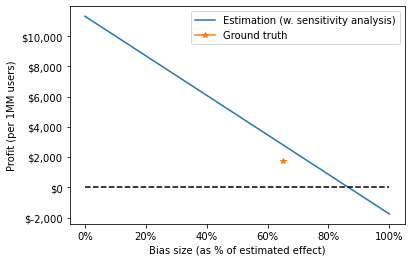

In [13]:
means = eval_df.groupby('treatment').visit.mean()
avg_effect = means.loc[1]-means.loc[0]

real_avg_bias = round(1 - avg_effect/biased_avg_effect, 2)

bias_sizes = np.arange(11)/10
benefits = []
for bias_size in bias_sizes:
    real_size = (1-bias_size)
    additional_visits = ((estimated_effects * real_size) * targeted).mean()
    benefit =  round((additional_visits*visit_value - targeted.mean()*ad_cost)*total_impressions)
    benefits.append(benefit)

figs = plt.plot(bias_sizes*100, benefits, label="Estimation (w. sensitivity analysis)")
plt.xlabel("Bias size (as % of estimated effect)")
plt.ylabel("Profit (per 1MM users)")
# Set Y axis
fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
figs[0].axes.yaxis.set_major_formatter(tick)
# Set X axis
figs[0].axes.xaxis.set_major_formatter(mtick.PercentFormatter())
# Break-even line
plt.plot([0, 100], [0, 0], linestyle='--', color='black')
plt.plot([real_avg_bias*100], [obs_benefit], marker="*", label="Ground truth")
plt.legend()
plt.savefig("sensitivity_analysis.png", dpi=200, bbox_inches="tight")

# Approach 2: What if there is some experimental data?

What's the best tree we could get with limited experimental data? 

In [14]:
limited_exp = exp_df.sample(50000,random_state=42)
limited_tree = fit_tree(limited_exp, tune=True, params=np.arange(1, 11)*1000)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Best parameters set found on development set:
{'min_samples_leaf': 1000}
--- Time to fit (and tune) causal tree 7.823261976242065 seconds ---


Compare each other. Experimental does better.

In [8]:
means = eval_df.groupby('treatment').visit.mean()
avg_effect = means.loc[1]-means.loc[0]
total_impressions = 1000000
size = 100

def plot_random(e_df):
    means = e_df.groupby('treatment').visit.mean()
    avg_effect = means.loc[1]-means.loc[0]
    fractions = (np.arange(size)+1)/size
    plt.plot(fractions*100, fractions*avg_effect*total_impressions, 
             color='black', linestyle='dashed', label="Random targeting")
    plt.legend()

def evaluate(e_df, title):
    e_df = e_df.sort_values('pred', ascending=False)
    cum_per = np.arange(e_df.shape[0]) / e_df.shape[0]
    fractions = []
    effects = []
    for i in range(size):
        targeted = cum_per < (i+1)/size
        fraction = targeted.mean()
        avg_outcomes = e_df[targeted].groupby('treatment').visit.mean()
        effect = (avg_outcomes.loc[1] - avg_outcomes.loc[0]) * fraction * total_impressions
        fractions.append(fraction)
        effects.append(effect)
    figs = plt.plot(np.array(fractions)*100, effects, label=title)
    plt.xlabel("% of users targeted")
    plt.ylabel("Increase in visits (per 1MM users)")
    # Set Y axis
    fmt = '{x:,.0f}'
    tick = mtick.StrMethodFormatter(fmt)
    figs[0].axes.yaxis.set_major_formatter(tick)
    # Set X axis
    figs[0].axes.xaxis.set_major_formatter(mtick.PercentFormatter())
    plt.legend()

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    2.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    4.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    4.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.2s finished


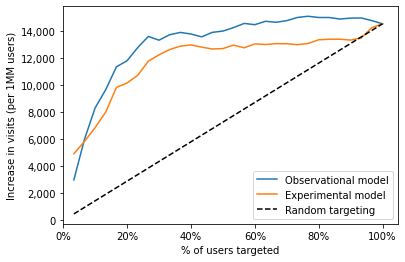

In [16]:
X = limited_exp[limited_features + ['treatment']].rename(columns={"treatment":"treated"})
y =  limited_exp.visit
exp_cross_preds = cross_val_predict(CausalForest(min_samples_leaf=limited_tree.min_samples_leaf, random_state=42, 
                                                 n_estimators=10), X, y, cv=10, verbose=10)

copy_exp_df = limited_exp.copy()
size=30
copy_exp_df['pred'] = obs_tree.predict(copy_exp_df[limited_features])
evaluate(copy_exp_df, "Observational model")
copy_exp_df['pred'] = exp_cross_preds
evaluate(copy_exp_df, "Experimental model")
plot_random(copy_exp_df)
plt.xlim(left=0)
plt.savefig("eval_comparison.png", dpi=200, bbox_inches="tight")

Average effect estimated by the experimental tree.

In [17]:
exp_cross_preds.mean() * 100

1.2585032074228768

Benefit evaluation

In [18]:
print("Observational")
copy_exp_df['pred'] = obs_tree.predict(copy_exp_df[limited_features])
obs_benefit = get_avg_benefit(copy_exp_df)
print("Experimental")
copy_exp_df['pred'] = exp_cross_preds
exp_benefit = get_avg_benefit(copy_exp_df)

Observational
Benefit ($) per 1 MM users: 3,742
Experimental
Benefit ($) per 1 MM users: 3,130


In [19]:
print("Observational")
eval_df['pred'] = obs_preds
obs_benefit = get_avg_benefit(eval_df)
print("Experimental")
eval_df['pred'] = limited_tree.predict(eval_df[limited_features])
exp_benefit = get_avg_benefit(eval_df)

Observational
Benefit ($) per 1 MM users: 1,753
Experimental
Benefit ($) per 1 MM users: 1,598


# Approach 3: What if we can invest in data?

In [ ]:
#eval_df['pred'] = obs_tree.predict(eval_df[limited_features])
#obs_benefit = get_avg_benefit(eval_df)
improvements = []
curve_sizes = np.array([25000, 50000, 100000, 200000, 400000])
for exp_size in curve_sizes:
    print(f"Experimental data size: {exp_size}")
    subset_exp = exp_df.sample(exp_size,random_state=42)
    subset_tree = fit_tree(subset_exp, tune=False, min_samples_leaf=limited_tree.min_samples_leaf)
    eval_df['pred'] = subset_tree.predict(eval_df[limited_features])
    exp_benefit = get_avg_benefit(eval_df)
    #improvement = 100 * (exp_benefit/obs_benefit - 1)
    print(f"Improvement: {improvement}")
    #improvements.append(improvement)
#improvements = np.array(improvements)

In [ ]:
eval_df['pred'] = 1
avg_benefit = get_avg_benefit(eval_df)

In [ ]:
breakevens = []
for size in curve_sizes[2:]:
    invested_size = size - curve_sizes[1]
    inference_size = eval_df.shape[0] - invested_size
    breakeven = 100 * (obs_benefit - avg_benefit) * invested_size / (inference_size * obs_benefit)
    breakevens.append(breakeven)
    print(breakeven)

In [ ]:
labels = ['25k', '50k', '100k', '200k', '400k']
plt.plot(labels, [0, 0] + breakevens, color='black', linestyle='dashed', label="Break-even improvement")
plt.plot(labels, improvements[:2].tolist() + [None, None, None], color='tab:orange', label="Learning curve, current data")
plt.plot(labels, [None] + improvements[1:].tolist(), color='tab:orange', linestyle='dotted', label="Learning curve, more data")
plt.gca().set_yticklabels(['{:.0f}%'.format(x) for x in plt.gca().get_yticks()])
plt.ylabel("Improvement of EM over OM")
plt.xlabel("Size of the experimental data")
plt.legend(loc='lower right')
plt.savefig("learning_curve.png", dpi=200, bbox_inches="tight")

# Confidence Intervals

In [27]:
visits = obs_df.groupby('treatment').visit.mean()
counts = obs_df.groupby('treatment').visit.count()
variances = obs_df.groupby('treatment').visit.var()
print(f"Naive confounded: {(visits[1] - visits[0])*100:.2f}%")
print(f"S.E.: {np.sqrt((variances/counts).sum())*100*1.96:.2f}%")
###################
visits = df.groupby('treatment').visit.mean()
counts = df.groupby('treatment').visit.count()
variances = df.groupby('treatment').visit.var()
print(f"Ground truth: {(visits[1] - visits[0])*100:.2f}%")
print(f"S.E.: {np.sqrt((variances/counts).sum())*100*1.96:.2f}%")

Naive confounded: 4.08%
S.E.: 0.03%
Ground truth: 1.03%
S.E.: 0.03%


Bootstrapping the experimental model.

In [22]:
from sklearn.utils import resample

bootstrap_size = 100
results = []
for i in range(bootstrap_size):
    print(i)
    data = resample(limited_exp, replace=True, random_state=i)
    tree = fit_tree(data, tune=False, min_samples_leaf=limited_tree.min_samples_leaf)
    result = tree.predict(data[limited_features]).mean()
    results.append(result)

0
--- Time to fit (and tune) causal tree 0.54060959815979 seconds ---
1
--- Time to fit (and tune) causal tree 0.5220036506652832 seconds ---
2
--- Time to fit (and tune) causal tree 0.5136191844940186 seconds ---
3
--- Time to fit (and tune) causal tree 0.5373034477233887 seconds ---
4
--- Time to fit (and tune) causal tree 0.4933624267578125 seconds ---
5
--- Time to fit (and tune) causal tree 0.5362660884857178 seconds ---
6
--- Time to fit (and tune) causal tree 0.4797847270965576 seconds ---
7
--- Time to fit (and tune) causal tree 0.5348711013793945 seconds ---
8
--- Time to fit (and tune) causal tree 0.5634500980377197 seconds ---
9
--- Time to fit (and tune) causal tree 0.6456456184387207 seconds ---
10
--- Time to fit (and tune) causal tree 0.5517866611480713 seconds ---
11
--- Time to fit (and tune) causal tree 0.5633797645568848 seconds ---
12
--- Time to fit (and tune) causal tree 0.5730924606323242 seconds ---
13
--- Time to fit (and tune) causal tree 0.5725953578948975 se

Unconfounded model: 1.37%
Unconfounded model (SE): 0.43%


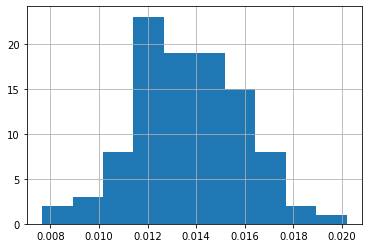

In [23]:
pd.Series(results).hist()
print(f"Unconfounded model: {np.mean(results)*100:.2f}%")
print(f"Unconfounded model (SE): {np.std(results)*100*1.96:.2f}%")

In [9]:
bootstrap_size = 10
results = []
for i in range(bootstrap_size):
    print(i)
    data = resample(obs_df, replace=True, random_state=i)
    #tree = fit_tree(data, tune=False, min_samples_leaf=obs_tree.min_samples_leaf)
    tree = fit_tree(data, tune=False, min_samples_leaf=32000)
    result = tree.predict(data[limited_features]).mean()
    results.append(result)

0
--- Time to fit (and tune) causal tree 208.7095718383789 seconds ---
1
--- Time to fit (and tune) causal tree 357.01459646224976 seconds ---
2
--- Time to fit (and tune) causal tree 353.66125321388245 seconds ---
3
--- Time to fit (and tune) causal tree 186.21985268592834 seconds ---
4
--- Time to fit (and tune) causal tree 196.14847135543823 seconds ---
5
--- Time to fit (and tune) causal tree 202.83232879638672 seconds ---
6
--- Time to fit (and tune) causal tree 190.43830251693726 seconds ---
7
--- Time to fit (and tune) causal tree 188.8630712032318 seconds ---
8
--- Time to fit (and tune) causal tree 197.38664031028748 seconds ---
9
--- Time to fit (and tune) causal tree 193.81672048568726 seconds ---


<AxesSubplot:>

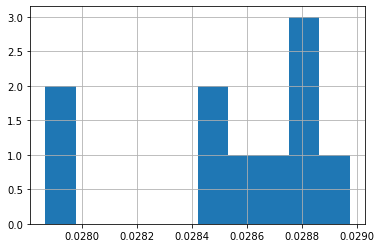

In [14]:
pd.Series(results).hist()

In [21]:
print(f"Confounded model: {pd.Series(results).mean()*100:.2f}%")
print(f"Confounded model S.E.: {pd.Series(results).std()*100*1.96:.2f}%")

Confounded model: 2.85%
Confounded model S.E.: 0.07%
